# Case LogComex
* Lucas Cardoso Polak

## 1. Uma análise exploratória da base, avaliando sazonalidades, outliers, etc.

* Como o objetivo final é realizar uma predição de uma combinação epecífica de fatores, minha EDA já será direcionada nesse sentido.

Dado que os arquivos são pequenos (Da ordem de MB), não é necessário lançar mão de computação distribuida como spark.

## EDA e Data Wrangling

In [1]:
import pandas as pd

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from category_encoders import TargetEncoder

# biblioteca gráfica
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
def define_combination_name(dataset):
    dataset = dataset.astype({
    'cod_ncm': int, 
    'hscode': int, 
    'urf_cod': int, 
    'via_transp_cod': int
    })
    # ['via_transp_cod'] = dataset['via_transp_cod'].astype(int)
    # dataset['urf_cod'] = dataset['urf_cod'].astype(int)
    # dataset['cod_ncm'] = dataset['cod_ncm'].astype(int)
    # dataset['hscode'] = dataset['hscode'].astype(int)
    dataset.loc[:, 'combinacao'] = dataset[COMBINACAO_TARGET].apply(lambda x: "_".join([str(c) for c in x.values]), axis=1)
    return dataset

In [3]:
#carregamento dos dados
df = pd.read_csv('./Data/historico_202001_202405.csv')

In [4]:
df.head()

,anomes,cod_ncm,hscode,cod_pais_origem,urf_cod,via_transp_cod,sgl_uf_import,city_cod,cidade_import,qtd_emb,qtd_imp,qtd_exp,tot_valor,tot_peso
0,202303,85176277,8517,160,817700.0,4.0,SP,3452205,SOROCABA,14,2,5,686970.17,3060.15
1,202208,84439933,8443,160,817800.0,1.0,SP,3452205,SOROCABA,14,2,2,192786.32,10766.40
2,202307,85176255,8517,160,817800.0,1.0,SP,3452205,SOROCABA,4,2,2,9085.65,47.65
3,202308,84439970,8443,160,817800.0,1.0,SP,3452205,SOROCABA,16,1,2,76159.33,13644.30
4,202205,87085099,8708,160,817800.0,1.0,SP,3409502,CAMPINAS,8,1,1,31832.38,257.28


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169637 entries, 0 to 169636
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   anomes           169637 non-null  int64  
 1   cod_ncm          169637 non-null  int64  
 2   hscode           169637 non-null  int64  
 3   cod_pais_origem  169637 non-null  int64  
 4   urf_cod          169420 non-null  float64
 5   via_transp_cod   169088 non-null  float64
 6   sgl_uf_import    169637 non-null  object 
 7   city_cod         169637 non-null  int64  
 8   cidade_import    169637 non-null  object 
 9   qtd_emb          169637 non-null  int64  
 10  qtd_imp          169637 non-null  int64  
 11  qtd_exp          169637 non-null  int64  
 12  tot_valor        169637 non-null  float64
 13  tot_peso         169637 non-null  float64
dtypes: float64(4), int64(8), object(2)
memory usage: 18.1+ MB


In [6]:
df.isna().sum()

anomes               0
cod_ncm              0
hscode               0
cod_pais_origem      0
urf_cod            217
via_transp_cod     549
sgl_uf_import        0
city_cod             0
cidade_import        0
qtd_emb              0
qtd_imp              0
qtd_exp              0
tot_valor            0
tot_peso             0
dtype: int64

In [7]:
#representatividade percentual de nulos
df.isna().sum()*100/df.shape[0]

anomes             0.000000
cod_ncm            0.000000
hscode             0.000000
cod_pais_origem    0.000000
urf_cod            0.127920
via_transp_cod     0.323632
sgl_uf_import      0.000000
city_cod           0.000000
cidade_import      0.000000
qtd_emb            0.000000
qtd_imp            0.000000
qtd_exp            0.000000
tot_valor          0.000000
tot_peso           0.000000
dtype: float64

### Primeiras impressões
* Analisando inicialmente os dados, nota-se que não é necessário fazer um importaçao mais avaçada (especificando sep, decimal, header, ... ) pois o arquivo já está bem formatado
* Comparando o formato dos dados com o dicionário de dados, nota-se que o tipo dos dados já está correto.
* Obs.: cod_ncm e hs_code possuem apenas 8 e 4 digitos resectivamente e não precisariam ser representados por um int64, Se fosse necessário otimizar espaço em memória, seria possível fazer o cast para int32, por exemplo.

#### Importante:
* 2 dos dados que compõe a combinação target possuem dados nulos (Baixa representatividade - menos de 0,5%)

* Necessário investigar se o Nulo possui algum valor preditivo (Uma UF específica é sempre nula). Se sim, um método de nan inputation será necessário. Caso contrário um drop pode ser uma boa opção.

* Uma outra boa opção seria conversar com um stakeholder para validar se num caso em produção, os Nulos deveriam ser tratados para sem preditos ou se seriam ignorados. 

In [8]:
# De acodo com o arquivo de especificação, devem existir 10 hscode para 4 estados.
# Se ao agrupar por essas variáveis eu tiver 40 combinações após um dropna, tenho um bom indício de que esses dados realmente não farão falta num caso de treinamento
df.dropna().groupby(['hscode', 'sgl_uf_import']).count().shape

(40, 12)

In [9]:
df_no_na = df.dropna()
df_no_na.isna().sum()

anomes             0
cod_ncm            0
hscode             0
cod_pais_origem    0
urf_cod            0
via_transp_cod     0
sgl_uf_import      0
city_cod           0
cidade_import      0
qtd_emb            0
qtd_imp            0
qtd_exp            0
tot_valor          0
tot_peso           0
dtype: int64

* cod_ncm e hscode são duas codificações para uma mesma mercadoria.
* Hipotese: existe uma única combinação de cod_ncm e hscode de forma que posso utilizar apenas 1?

In [10]:
df_no_na.groupby(['cod_ncm', 'hscode']).count()

,,anomes,cod_pais_origem,urf_cod,via_transp_cod,sgl_uf_import,city_cod,cidade_import,qtd_emb,qtd_imp,qtd_exp,tot_valor,tot_peso
cod_ncm,hscode,,,,,,,,,,,,
29151100,2915,478,478,478,478,478,478,478,478,478,478,478,478
29151210,2915,143,143,143,143,143,143,143,143,143,143,143,143
29151290,2915,198,198,198,198,198,198,198,198,198,198,198,198
29151310,2915,8,8,8,8,8,8,8,8,8,8,8,8
29151390,2915,106,106,106,106,106,106,106,106,106,106,106,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90189092,9018,141,141,141,141,141,141,141,141,141,141,141,141
90189094,9018,87,87,87,87,87,87,87,87,87,87,87,87
90189095,9018,440,440,440,440,440,440,440,440,440,440,440,440


In [11]:
# confirmação de que os 4 primeiros digitos do cod_ncm são iguais ao hscode
np.all(df_no_na['cod_ncm']//10000 == df_no_na['hscode'])

True

## NCM 
* (Nomenclatura Comum do Mercosul) é um código de oito dígitos estabelecido pela legislação federal para identificar as mercadorias e facilitar o comércio internacional
* https://www.gov.br/receitafederal/pt-br/assuntos/aduana-e-comercio-exterior/classificacao-fiscal-de-mercadorias/ncm

#### Conclusão:
 - O hscode parece ser o descritivo macro da mercadoria e os primeiros 4 digitos do cod_ncm, porém os últimos 4 dígitos do cod_ncm podem indicar algumaoutra especificação da mercadoria
 - Aparentemente utilizar apenas o cod_ncm já seria suficiente, para essa task, porém o ideal seria confirmar essa informação com o dono do dado ou algum stakeholder para ter completa certeza disso
 - Para a sequência dessa task irei utilizar apenas o cod_ncm para simplificar as análises

In [12]:
# validação se o dataset contém somente dados da China:
df_no_na['cod_pais_origem'].unique()

array([160])

#### Conclusão:
- Dado que o dataset possui unicamente dados da China, posso remover essa coluna do dataset

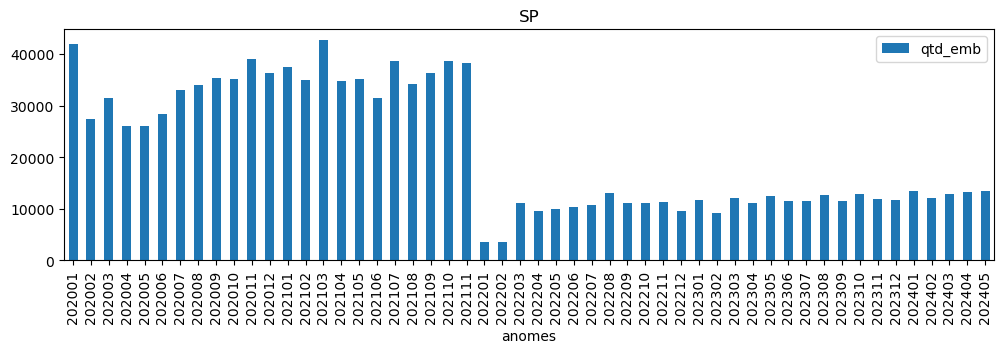

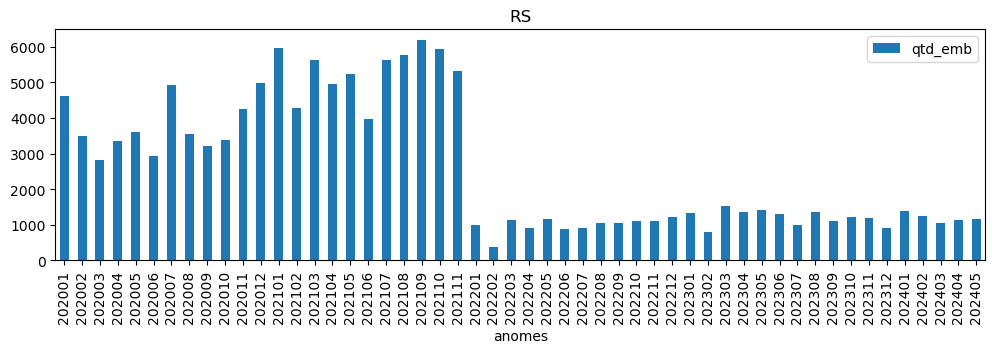

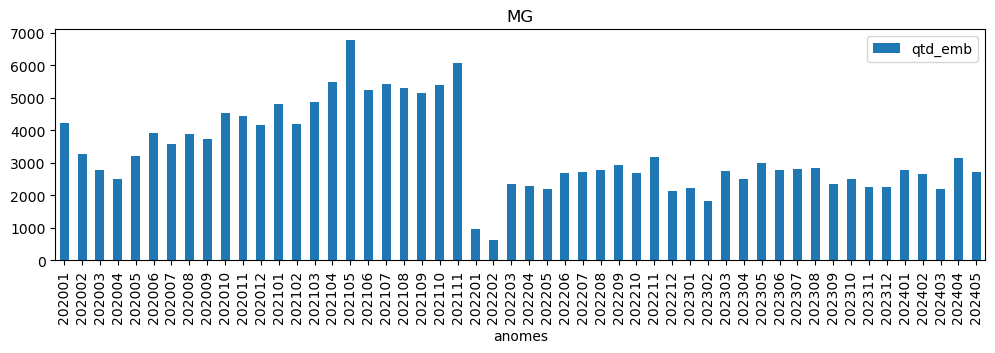

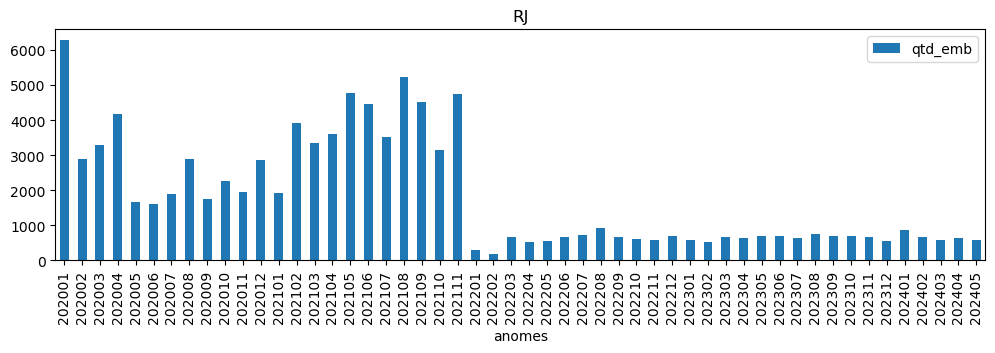

In [13]:
plt.rcParams['figure.figsize']= (12,3)
for i in df_no_na['sgl_uf_import'].unique():
    df_no_na[df_no_na['sgl_uf_import']==i].groupby(['anomes']).agg({'qtd_emb':sum}).sort_index().plot.bar()
    plt.title(i)

## Análise
* em todos os Estados houve uma grande queda em importações da China a partir do ano de 2022
* Algum efeito da pandemia do Covid19? Alguma lei de importação?
* São Paulo é disparado o maior importador
* Como o objetivo final é saber se haverá ou não importação e não o volume importado, essa "descontinuidade" no dado não deve influenciar

In [14]:
df_clean = df_no_na.drop(['cod_pais_origem',], axis=1) #'hscode', 

In [15]:
COMBINACAO_TARGET = ['cod_ncm',  
                     'hscode',
                    'urf_cod',
                    'via_transp_cod', 
                    'sgl_uf_import']

## validação de datas
* Aparentemente só tenho casos positivos no dadaset, então vou precisar gerar os casos dos meses em que a combinação não existiu para poder treinar um classificador

In [16]:
df_clean.groupby(COMBINACAO_TARGET).size().reset_index()[0].value_counts()

0
1      2133
2       899
3       543
4       380
5       327
       ... 
489       1
183       1
303       1
112       1
141       1
Name: count, Length: 294, dtype: int64

* Muitos casos aparecem poucas vezes no datase, podendo gerar um certo vies

In [17]:
#verificando se existe algum mês em que não houve embarque:
df_clean.qtd_emb.min()
# Como o mínimo de embarque existente é 1, realmente não existem casos negativos para cada anomes possível

1

### Geração de frequência para cada combinação
* Como temos apenas exemplos positivos, irei criar um dataset complementando os casos negativos

In [18]:
df_clean.anomes.min(), df_clean.anomes.max()

(202001, 202405)

In [19]:
data_range = pd.date_range(start='2020-01-01', end='2024-06-01', freq='M')
df_data_range = pd.DataFrame([int(x.strftime('%Y%m')) for x in data_range], columns=['anomes'])

In [20]:
df_data_range.head(3)

,anomes
0,202001
1,202002
2,202003


In [21]:
df_clean.head(2)

,anomes,cod_ncm,hscode,urf_cod,via_transp_cod,sgl_uf_import,city_cod,cidade_import,qtd_emb,qtd_imp,qtd_exp,tot_valor,tot_peso
0,202303,85176277,8517,817700.0,4.0,SP,3452205,SOROCABA,14,2,5,686970.17,3060.15
1,202208,84439933,8443,817800.0,1.0,SP,3452205,SOROCABA,14,2,2,192786.32,10766.40


## Hipotese: 
* Existe alguma relação de importação exportação nas variáveis qtd_emb, qtd_imp e qtd_exp que ajude na predição?
* Alguma forma de encoding que auxilie?nas

In [22]:
df_grupos = df_clean.groupby(['anomes', *COMBINACAO_TARGET]).size()
df_grupos = df_grupos.reset_index().rename({0: 'target'}, axis=1)
df_grupos['target'] = 1
df_grupos.head(10)

,anomes,cod_ncm,hscode,urf_cod,via_transp_cod,sgl_uf_import,target
0,202001,29151100,2915,817800.0,1.0,MG,1
1,202001,29151100,2915,817800.0,1.0,SP,1
2,202001,29151100,2915,917800.0,1.0,RS,1
3,202001,29151100,2915,1010252.0,7.0,RS,1
4,202001,29151100,2915,1017700.0,1.0,RS,1
5,202001,29151210,2915,917800.0,1.0,RS,1
6,202001,29151210,2915,1017700.0,1.0,RS,1
7,202001,29151290,2915,817600.0,4.0,SP,1
8,202001,29151290,2915,817800.0,1.0,SP,1
9,202001,29151390,2915,1017700.0,1.0,RS,1


In [23]:
df_grupos.shape

(76511, 7)

In [24]:
df_grupos_target_1 = df_grupos.groupby(COMBINACAO_TARGET)


In [25]:
df_completo = None
for g in df_grupos_target_1.groups.keys():
    
    def_merge = df_data_range.merge(df_grupos_target_1.get_group(g)
                    , on='anomes'
                    , how='left')
    
    def_merge = def_merge.fillna({'target': 0}).ffill().bfill()
    
    if df_completo is None:
        df_completo = def_merge
    else:
        df_completo = pd.concat([df_completo, def_merge])

In [26]:
df_completo.shape

(404867, 7)

In [27]:
df_completo.isna().sum()

anomes            0
cod_ncm           0
hscode            0
urf_cod           0
via_transp_cod    0
sgl_uf_import     0
target            0
dtype: int64

In [28]:
df_completo.sample(10)

,anomes,cod_ncm,hscode,urf_cod,via_transp_cod,sgl_uf_import,target
47,202312,84433910.0,8443.0,1010252.0,7.0,RS,0.0
10,202011,29211999.0,2921.0,927800.0,1.0,SP,0.0
14,202103,90183926.0,9018.0,817600.0,4.0,SP,0.0
32,202209,87089100.0,8708.0,1017801.0,4.0,RS,0.0
12,202101,85414024.0,8541.0,1017800.0,4.0,RS,0.0
38,202303,85412191.0,8541.0,817700.0,4.0,RS,1.0
4,202005,29339956.0,2933.0,817600.0,4.0,SP,0.0
33,202210,85411021.0,8541.0,927800.0,1.0,SP,0.0
6,202007,85412199.0,8541.0,817700.0,1.0,SP,0.0
24,202201,29335200.0,2933.0,817700.0,4.0,RS,0.0


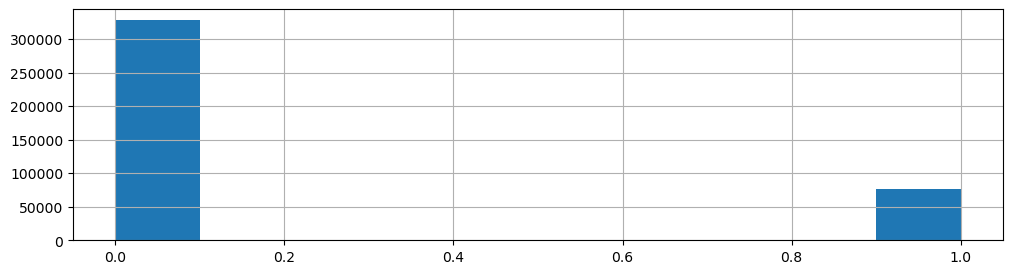

In [29]:
df_completo['target'].hist();

In [30]:
# dataset bastante desbalanceado, até mesmo por conta das muitas observações com apenas 1 dado de importação

In [31]:
# Dando um nome para a combinação apenas para facilitar encontrá-la no dataset para análises posteriores
#df_completo.drop('combinacao', axis=1, errors='ignore', inplace=True)
df_completo = define_combination_name(df_completo)
#df_completo['combinacao'] = df_completo[COMBINACAO_TARGET].apply(lambda x: "_".join([str(c) for c in x.values]), axis=1)

In [32]:
df_completo.sample(10)

,anomes,cod_ncm,hscode,urf_cod,via_transp_cod,sgl_uf_import,target,combinacao
42,202307,87084090,8708,1010351,7,SP,0.0,87084090_8708_1010351_7_SP
22,202111,85177091,8517,727600,1,MG,0.0,85177091_8517_727600_1_MG
38,202303,29155020,2915,927700,1,RS,0.0,29155020_2915_927700_1_RS
43,202308,85414025,8541,617700,4,MG,0.0,85414025_8541_617700_4_MG
17,202106,29331990,2933,817800,1,RJ,0.0,29331990_2933_817800_1_RJ
21,202110,85171212,8517,817700,4,SP,1.0,85171212_8517_817700_4_SP
47,202312,85414032,8541,317900,1,SP,0.0,85414032_8541_317900_1_SP
28,202205,29412090,2941,617700,1,MG,0.0,29412090_2941_617700_1_MG
22,202111,90189010,9018,817600,4,RS,0.0,90189010_9018_817600_4_RS
47,202312,29153993,2915,817700,4,SP,0.0,29153993_2915_817700_4_SP


### Sazonalidade: 
* Verificações de sazonalizadade dentro do dataset

In [33]:
#apenas para deixar alguns plots mais visuais, vou transformar o anomes em uma data
df_completo['data'] = df_completo.apply(lambda x: pd.to_datetime(str(x['anomes']*100 +1), format="%Y%m%d"), axis=1)

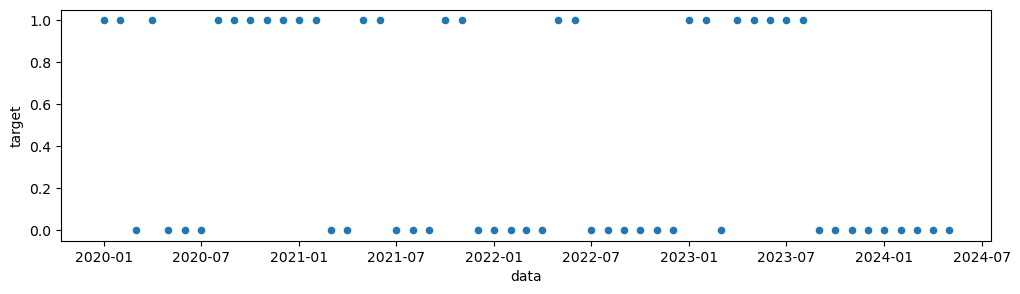

In [34]:
# primeira exploração visual
df_completo.loc[(df_completo['combinacao'] == '87082919_8708_927800_1_SP')]\
            .sort_values('anomes')\
            .plot.scatter(x='data', y='target');

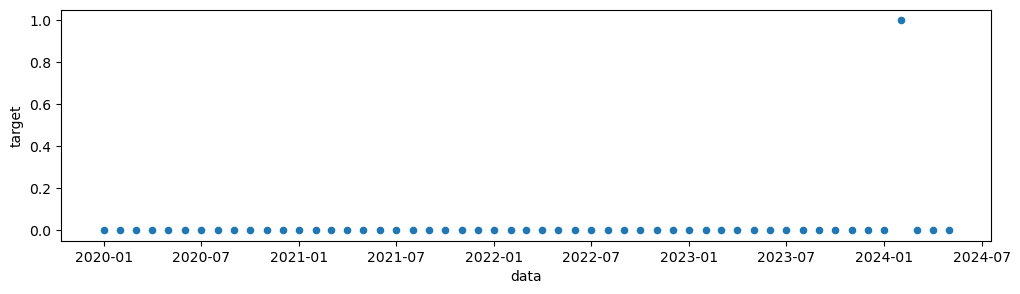

In [35]:
df_completo.loc[df_completo['combinacao'] == '29151100_2915_517800_1_MG'].sort_values('anomes').plot.scatter(x='data', y='target');

In [36]:
def define_periodo_sazonalidade(sinal):
    """
    Retorna o possível período de uma sazonalidade com base na autocorrelação dos dados.
    Casão não encontre uma sazonalidade, retorna -1
    """
    try:
        acf = np.correlate(sinal, sinal, 'full')[-len(sinal):]
        inflection = np.diff(np.sign(np.diff(acf)))
        picos = (inflection < 0).nonzero()[0]+1
        return picos[acf[picos].argmax()]
    except:
        return -1

In [37]:
sinal = df_completo.loc[(df_completo['combinacao'] == '87082919_8708_927800_1_SP')]\
            .sort_values('anomes')['target'].values

define_periodo_sazonalidade(sinal)

4

In [38]:
periodo_encoder = {}
for c in df_completo['combinacao'].unique():
    periodo_encoder[c] = define_periodo_sazonalidade(df_completo.loc[df_completo['combinacao'] == c, 'target'].values)

In [39]:
acorr_ljungbox(df_completo.loc[(df_completo['combinacao'] == '87082919_8708_927800_1_SP')]\
            .sort_values('anomes')['target'].values, auto_lag=True)
# validando a auto correlação da série para validar se em algum momento ela "se repete" (não necessáriamente com perfeição), indicando uma possível sazonalidade

,lb_stat,lb_pvalue
1,9.166513,0.002465


## Análise:
* Visualmente parece haver sazonalidade nas importações em algumas combinações
* Outros combinações tem pouquissimos dados para realizarmos essa inferência e podem inclusive gerar vies na análise e posteriormente no modelo
* IMPORTANTE: aqui o correto seria aplicar um teste estatístico de sazonalidade (como Jung-Box) para cada uma das combinações possíveis, entretanto por simplicidade, nesse momento irei assumir que existe sazonalidade e gerar uma feature cíclica relacionada aos meses do ano.
* Para features categóricas de baixa cardinalidade, irei utilizar o one hot enconding
* Isso será utilizado como modelo baseline, sendo que posteriormente será possível melhorá-lo

# Feature engineering

In [40]:
df_completo.head(1)

,anomes,cod_ncm,hscode,urf_cod,via_transp_cod,sgl_uf_import,target,combinacao,data
0,202001,29151100,2915,517800,1,MG,0.0,29151100_2915_517800_1_MG,2020-01-01


In [41]:
# df_to_model.columns.astype(str) 

In [42]:
# df_to_model = pd.concat([df_to_model, df_completo[['anomes', 'cod_ncm', 'urf_cod', 'target', 'combinacao', 'data']]], axis=1)

# df_to_model.columns = df_to_model.columns.astype(str) 
# df_to_model = df_completo

In [43]:
df_train = df_completo.loc[df_completo['data'] < '2024-05-01']
df_test = df_completo.loc[df_completo['data'] >= '2024-05-01']


### Encodings
* Vou iniciar com features bastante simples para o baseline e posteriormente posso evoluir em features mais avançadas.
* Conhecimento de negócio também é algo essencial nessa etapa, então em conversar com áreas de negócio e tambem técnicas encolvidas nessa demanda, seria possível refinar as features
* Outra possibilidade seria buscar um entendimetno mais profundo sobre a importação decada um dos códigos(produtos) importados em dados externos que pudessem gerar insights sobre features

In [44]:
df_train

,anomes,cod_ncm,hscode,urf_cod,via_transp_cod,sgl_uf_import,target,combinacao,data
0,202001,29151100,2915,517800,1,MG,0.0,29151100_2915_517800_1_MG,2020-01-01
1,202002,29151100,2915,517800,1,MG,0.0,29151100_2915_517800_1_MG,2020-02-01
2,202003,29151100,2915,517800,1,MG,0.0,29151100_2915_517800_1_MG,2020-03-01
3,202004,29151100,2915,517800,1,MG,0.0,29151100_2915_517800_1_MG,2020-04-01
4,202005,29151100,2915,517800,1,MG,0.0,29151100_2915_517800_1_MG,2020-05-01
...,...,...,...,...,...,...,...,...,...
47,202312,90189099,9018,9999999,4,RS,0.0,90189099_9018_9999999_4_RS,2023-12-01
48,202401,90189099,9018,9999999,4,RS,0.0,90189099_9018_9999999_4_RS,2024-01-01
49,202402,90189099,9018,9999999,4,RS,0.0,90189099_9018_9999999_4_RS,2024-02-01
50,202403,90189099,9018,9999999,4,RS,0.0,90189099_9018_9999999_4_RS,2024-03-01


In [45]:
encoder_via_trans = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_hscode = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_sgl_uf_import = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoder_via_trans.fit(df_train[['via_transp_cod']])
encoder_hscode.fit(df_train[['hscode']])
encoder_sgl_uf_import.fit(df_train[['sgl_uf_import']]);


target_encoder = TargetEncoder(verbose=2, cols=COMBINACAO_TARGET)
target_encoder = target_encoder.fit(df_train[COMBINACAO_TARGET], df_train['target'])

In [67]:
def feature_periodo(dataset):
    periodo = pd.DataFrame.from_dict({'periodo': periodo_encoder}).reset_index().rename({'index':'combinacao'}, axis=1)
    dataset = define_combination_name(dataset)
    dataset = dataset.merge(periodo, on='combinacao', how='left').fillna(-1)
    return dataset
    
def oneHotEncoding(dataset):
    """
       Função auxiliar para transformação do dataset
    """
    dataset = pd.concat([dataset.reset_index(drop=True), pd.DataFrame(encoder_via_trans.transform(dataset[['via_transp_cod']]), columns=encoder_via_trans.categories_[0].astype(str))], axis=1)
    dataset = pd.concat([dataset.reset_index(drop=True), pd.DataFrame(encoder_hscode.transform(dataset[['hscode']]), columns=encoder_hscode.categories_[0].astype(str))], axis=1)
    dataset = pd.concat([dataset.reset_index(drop=True), pd.DataFrame(encoder_sgl_uf_import.transform(dataset[['sgl_uf_import']]), columns=encoder_sgl_uf_import.categories_[0].astype(str))], axis=1)
    return dataset

def cyclicEncoding(dataset):
    """
    Como a data não é dada no dataset de validação, não posso usar essa feature
    """
    dataset = pd.concat([dataset.reset_index(drop=True), pd.Series((np.sin(dataset['data'].dt.month-1)/5.5), name='seno_mes')], axis=1)
    dataset = pd.concat([dataset.reset_index(drop=True), pd.Series((np.cos(dataset['data'].dt.month-1)/5.5), name='cosseno_mes')], axis=1)
    return dataset
    
def create_features_target(dataset):
    dataset = oneHotEncoding(dataset)
    dataset = cyclicEncoding(dataset)
    # dataset = feature_periodo(dataset) # removido, pois apresentou indicios de overfit
    
    x = dataset.drop(['anomes', 'cod_ncm', 'urf_cod', 'target', 'combinacao', 'data', 'sgl_uf_import', 'hscode', 'via_transp_cod'], axis=1, errors='ignore')
    if 'target' in dataset.columns:
        y = dataset['target']
    else:
        y=None
    #x = pd.concat([x.reset_index(drop=True), target_encoder.transform(dataset[COMBINACAO_TARGET])], axis=1) # removido, pois estava gerando overfit
    
    return x, y
    

In [68]:
x_test, y_test = create_features_target(df_test)
x_train, y_train = create_features_target(df_train)

In [69]:
# Vou iniciar com uma randon forest, um algorítmo não liear bastante robustoe que pode ser utilizado como um baseline
rf= RandomForestClassifier(random_state=2024)

In [70]:
rf.fit(x_train, y_train, sample_weight=(y_train+0.5)*5)
# dando mais importência aos exemplos de treinamento positivo
# poeria utulizar um undersampling ou over sampling, porém para o baseline sigo com a abordagem mais simples

RandomForestClassifier(random_state=2024)

In [71]:
y_pred = rf.predict(x_test)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83      6144
         1.0       0.32      0.37      0.34      1495

    accuracy                           0.72      7639
   macro avg       0.58      0.59      0.58      7639
weighted avg       0.74      0.72      0.73      7639



In [73]:
print(classification_report(y_train, rf.predict(x_train)))

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82    322212
         1.0       0.31      0.37      0.33     75016

    accuracy                           0.72    397228
   macro avg       0.58      0.59      0.58    397228
weighted avg       0.74      0.72      0.73    397228



In [74]:
matriz_confusao = confusion_matrix(y_test, y_pred)

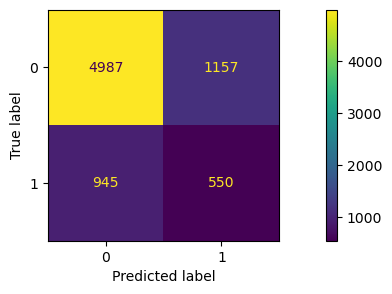

In [75]:
ConfusionMatrixDisplay(matriz_confusao).plot()

In [76]:
dataset_test = pd.read_csv('./Data/base_teste_202405.csv')
dataset_test['anomes'] = 202405
dataset_test = dataset_test.rename({'combinacao_202405':'target'}, axis=1)
dataset_test['data'] = dataset_test.apply(lambda x: pd.to_datetime(str(x['anomes']*100 +1), format="%Y%m%d"), axis=1)

In [77]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18067 entries, 0 to 18066
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cod_ncm          18067 non-null  int64         
 1   hscode           18067 non-null  int64         
 2   cod_pais_origem  18067 non-null  int64         
 3   urf_cod          18067 non-null  int64         
 4   via_transp_cod   18067 non-null  int64         
 5   sgl_uf_import    18067 non-null  object        
 6   city_cod         18067 non-null  int64         
 7   cidade_import    18067 non-null  object        
 8   target           18067 non-null  int64         
 9   anomes           18067 non-null  int64         
 10  data             18067 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 1.5+ MB


In [78]:
x, y = create_features_target(dataset_test)
x = x.drop(['cod_pais_origem',
'city_cod',
'cidade_import'],axis=1)

In [79]:
y_pred_test = rf.predict(x)

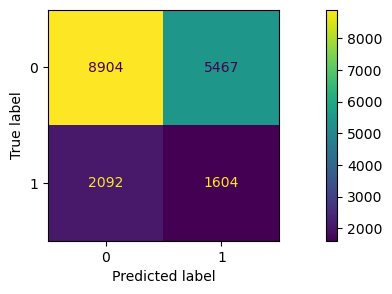

In [80]:
ConfusionMatrixDisplay(confusion_matrix(y, y_pred_test)).plot()

In [81]:
print(classification_report(y, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.62      0.70     14371
           1       0.23      0.43      0.30      3696

    accuracy                           0.58     18067
   macro avg       0.52      0.53      0.50     18067
weighted avg       0.69      0.58      0.62     18067



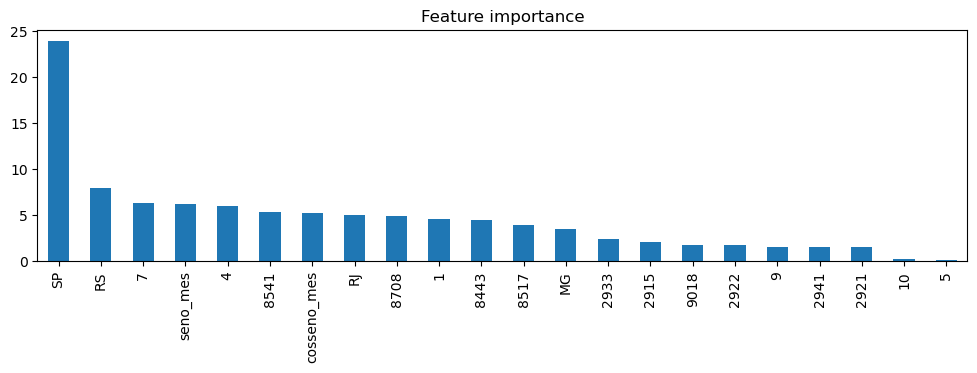

In [82]:
pd.Series(rf.feature_importances_*100, index=x_test.columns).sort_values(ascending=False).plot.bar(title='Feature importance');

# Evoluções:
* Como proximos passos em termos de modelo, poderia realizar a otimmização de hiperparâmetros
* No aso de algoritmos de árvores ou não probabilísiticos ainda seria necessário realizar a calibração para maior assertividade
* IMPORTANTE: Mais do que melhorar o modelo, seria necessário um aprofundamento em EDA e feature engineering para melhorar a explicabilidade dos dados e buscar mais assertividade

# Validação:

* Idealmente deveria fazer o selec das features selecionadas e não o drop das demais.
* Nesse momento optei pelo drop por simplicidade

In [83]:
dataset_validacao_original = pd.read_csv('./Data/base_validacao_mes.csv')

In [84]:
results = []
for i in [202406, 202407]:
    dataset_validacao = dataset_validacao_original.copy()
    dataset_validacao['anomes'] = i
    dataset_validacao['data'] = dataset_validacao.apply(lambda x: pd.to_datetime(str(x['anomes']*100 +1), format="%Y%m%d"), axis=1)
    x, y = create_features_target(dataset_validacao)
    x = x.drop(['cod_pais_origem',
                'city_cod',
                'cidade_import', 
                'combinacao_202406', 
                'combinacao_202407'],axis=1)
    
    results.append(rf.predict(x))

In [85]:
dataset_validacao_original['combinacao_202406'] = results[0]
dataset_validacao_original['combinacao_202407'] = results[1]

In [86]:
# verificando o percentual de diferença entre os meses
dataset_validacao_original.loc[dataset_validacao_original['combinacao_202406'] != dataset_validacao_original['combinacao_202407']].shape[0]*100/dataset_validacao_original.shape[0]

3.6087895057286765

In [87]:
# dataset_validacao_original.to_csv('results.csv')